# Config

In [9]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm
import warnings

# Suppress warnings from scikit-learn about feature names
warnings.filterwarnings("ignore", category=UserWarning)

# --- CONFIGURATION ---
class Config:
    # --- Data Paths ---
    # The root directory of your dataset
    DATASET_ROOT = "./dataset_v4" 

    # --- Feature Engineering (HOG) ---
    HOG_ORIENTATIONS = 9
    HOG_PIXELS_PER_CELL = (8, 8)
    HOG_CELLS_PER_BLOCK = (2, 2)

    # --- Model & Workflow ---
    PLATE_WINDOW_SIZE = (100, 40)
    
    # --- Evaluation ---
    IOU_THRESHOLD = 0.5

# PREPROCESSING

## Load and preprocess data

In [10]:
def load_yolo_dataset(root_dir, split='train'):
    """
    Loads an image dataset from a YOLO-formatted directory.
    Converts YOLO coordinates to absolute pixel coordinates [x1, y1, x2, y2].
    
    --- CORRECTED to handle multi-line/multi-value annotation files ---
    """
    print(f"--- Part 1: Loading '{split}' dataset from YOLO format ---")
    image_paths = []
    annotations = []
    
    img_dir = os.path.join(root_dir, split, 'images')
    lbl_dir = os.path.join(root_dir, split, 'labels')
    
    if not os.path.isdir(img_dir):
        print(f"Error: Directory not found - {img_dir}")
        return [], []

    for fname in sorted(os.listdir(img_dir)):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(img_dir, fname)
            
            img = cv2.imread(img_path)
            if img is None: continue
            img_height, img_width, _ = img.shape
            
            lbl_fname = os.path.splitext(fname)[0] + '.txt'
            lbl_path = os.path.join(lbl_dir, lbl_fname)
            
            if os.path.exists(lbl_path):
                with open(lbl_path, 'r') as f:
                    # FIX: Read only the first line to avoid errors with multiple annotations.
                    line = f.readline().strip()
                    
                    if line: # Ensure the line is not empty
                        parts = line.split()
                        
                        # FIX: Ensure we have at least 5 parts and only use the first 5.
                        # This makes the code robust to formats with extra values (e.g., confidence scores).
                        if len(parts) >= 5:
                            # Unpack the first 5 values corresponding to class, x, y, w, h
                            _, x_c, y_c, w, h = map(float, parts[:5])
                            
                            # Convert to absolute pixel coordinates
                            x_c_abs = x_c * img_width
                            y_c_abs = y_c * img_height
                            w_abs = w * img_width
                            h_abs = h * img_height
                            
                            x1 = int(x_c_abs - w_abs / 2)
                            y1 = int(y_c_abs - h_abs / 2)
                            x2 = int(x_c_abs + w_abs / 2)
                            y2 = int(y_c_abs + h_abs / 2)
                            
                            image_paths.append(img_path)
                            annotations.append([x1, y1, x2, y2])

    print(f"Loaded {len(image_paths)} images and annotations from '{split}' split.\n")
    return image_paths, annotations

def preprocess_image(image):
    """Applies standard preprocessing steps."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    return enhanced

def preprocess_image(image):
    """Applies standard preprocessing steps."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    return enhanced

## Feature Engineering

In [11]:
def extract_hog_features(image_patch):
    """Extracts HOG features from a given image patch."""
    resized_patch = cv2.resize(image_patch, Config.PLATE_WINDOW_SIZE)
    features = hog(resized_patch, 
                   orientations=Config.HOG_ORIENTATIONS,
                   pixels_per_cell=Config.HOG_PIXELS_PER_CELL,
                   cells_per_block=Config.HOG_CELLS_PER_BLOCK,
                   transform_sqrt=True,
                   feature_vector=True)
    return features

def prepare_training_data(image_paths, annotations, num_neg_samples_per_img=10):
    """Prepares positive (plates) and negative (non-plates) HOG features."""
    print("--- Part 2: Preparing Training Data (Extracting HOG Features) ---")
    positive_features = []
    negative_features = []

    for i in tqdm(range(len(image_paths)), desc="Extracting Features"):
        img = cv2.imread(image_paths[i])
        processed_img = preprocess_image(img)
        
        # --- Positive Sample ---
        x1, y1, x2, y2 = annotations[i]
        plate_patch = processed_img[y1:y2, x1:x2]
        if plate_patch.size > 0:
            positive_features.append(extract_hog_features(plate_patch))
        
        # --- Negative Samples ---
        count = 0
        h_img, w_img = processed_img.shape
        h_win, w_win = Config.PLATE_WINDOW_SIZE[1], Config.PLATE_WINDOW_SIZE[0]

        while count < num_neg_samples_per_img:
            rand_x = random.randint(0, w_img - w_win)
            rand_y = random.randint(0, h_img - h_win)
            
            # Check for overlap with the ground truth box to ensure it's a true negative
            pred_box = [rand_x, rand_y, rand_x + w_win, rand_y + h_win]
            iou = calculate_iou(annotations[i], pred_box)

            if iou < 0.1:
                neg_patch = processed_img[rand_y:rand_y+h_win, rand_x:rand_x+w_win]
                negative_features.append(extract_hog_features(neg_patch))
                count += 1

    print(f"Extracted {len(positive_features)} positive and {len(negative_features)} negative samples.\n")
    return positive_features, negative_features

## Method 1 - HOG + SVM Training

In [12]:
def train_svm_classifier(positive_features, negative_features):
    """Trains a Linear SVM and finds the best hyperparameter 'C' using GridSearchCV."""
    print("--- Part 3: Training HOG + SVM Classifier ---")
    
    X = np.vstack((positive_features, negative_features)).astype(np.float32)
    y = np.array([1] * len(positive_features) + [0] * len(negative_features))
    
    param_grid = {'C': [0.1, 1, 10]}
    model = GridSearchCV(LinearSVC(dual=False, random_state=42, max_iter=10000), param_grid, cv=3, n_jobs=-1)
    
    print("Running GridSearchCV (Cross-Validation + Hyperparameter Tuning)...")
    model.fit(X, y)
    
    print(f"Best Hyperparameter found: {model.best_params_}")
    print(f"Best cross-validation score: {model.best_score_:.4f}\n")
    return model.best_estimator_

## Method 2 - Haar Cascade

In [13]:
def explain_and_use_haar_cascade(test_image_path):
    """Explains Haar training and demonstrates usage of a pre-trained file."""
    print("--- Part 4: Method 2 - Viola-Jones (Haar Cascade) ---")
    print("TRAINING a custom Haar Cascade is done via command line, not in Python.")
    print("1. Collect positive samples (your plates, cropped) and negative images (no plates).")
    print("2. Use `opencv_createsamples` to generate a .vec file from positive samples.")
    print("3. Use `opencv_traincascade` to train the classifier. Example command:")
    print("   `opencv_traincascade -data cascade/ -vec samples.vec -bg negatives.txt -numStages 20 -w 100 -h 40`\n")
    print("DEMONSTRATING usage with OpenCV's pre-trained Russian plate detector:")

    try:
        cascade_path = os.path.join(cv2.data.haarcascades, 'haarcascade_russian_plate_number.xml')
        plate_cascade = cv2.CascadeClassifier(cascade_path)
        if plate_cascade.empty(): raise IOError("Cascade file not loaded")
    except Exception as e:
        print(f"Could not load Haar cascade. It might not be included in your OpenCV build. Error: {e}")
        return

    img = cv2.imread(test_image_path)
    if img is None: return
    processed_img = preprocess_image(img)
    
    plates = plate_cascade.detectMultiScale(processed_img, scaleFactor=1.1, minNeighbors=5)
    
    print(f"Viola-Jones found {len(plates)} potential plates in the test image.")
    img_copy = img.copy()
    for (x, y, w, h) in plates:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 3) # Blue box
    
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title("Viola-Jones Detection Result")
    plt.axis('off')
    plt.show()

# Evaluation

In [14]:
def sliding_window_detector(image, model):
    """Runs a sliding window over the image to detect plates."""
    h_win, w_win = Config.PLATE_WINDOW_SIZE[1], Config.PLATE_WINDOW_SIZE[0]
    step_size = 10
    detections = []
    scores = []

    for y in range(0, image.shape[0] - h_win, step_size):
        for x in range(0, image.shape[1] - w_win, step_size):
            patch = image[y:y+h_win, x:x+w_win]
            features = extract_hog_features(patch)
            score = model.decision_function([features])
            if score > 0.5: # Confidence threshold
                detections.append([x, y, x + w_win, y + h_win])
                scores.append(score[0])
    return np.array(detections), np.array(scores)

def non_maximum_suppression(boxes, scores, overlap_thresh):
    """Applies NMS to merge overlapping bounding boxes."""
    if len(boxes) == 0: return [], []
    pick = []
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    while len(idxs) > 0:
        i = idxs[-1]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])
        w_inter, h_inter = np.maximum(0, xx2 - xx1 + 1), np.maximum(0, yy2 - yy1 + 1)
        inter = w_inter * h_inter
        overlap = inter / (area[i] + area[idxs[:-1]] - inter)
        idxs = np.delete(idxs, np.concatenate(([len(idxs) - 1], np.where(overlap > overlap_thresh)[0])))
    return boxes[pick].astype("int"), scores[pick]

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union between two boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea) if float(boxAArea + boxBArea - interArea) > 0 else 0

In [ ]:
import seaborn as sns # Used for a nicer looking confusion matrix

def plot_detection_gallery(tp_examples, fn_examples, fp_examples, num_examples=2):
    """Creates a gallery of detection examples."""
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    fig.suptitle('Detection Examples Gallery', fontsize=16)

    # Titles for columns
    axes[0, 0].set_title(f'Correct Detections (TPs)', color='green')
    axes[0, 1].set_title(f'Missed Detections (FNs)', color='orange')
    axes[0, 2].set_title(f'False Alarms (FPs)', color='red')

    for i in range(num_examples):
        # --- True Positives ---
        if i < len(tp_examples):
            img_path, pred_box, gt_box = tp_examples[i]
            img = cv2.imread(img_path)
            cv2.rectangle(img, tuple(gt_box[:2]), tuple(gt_box[2:]), (0, 255, 0), 2) # Green GT
            cv2.rectangle(img, tuple(pred_box[:2]), tuple(pred_box[2:]), (0, 0, 255), 2) # Red Pred
            axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, 0].axis('off')

        # --- False Negatives ---
        if i < len(fn_examples):
            img_path, gt_box = fn_examples[i]
            img = cv2.imread(img_path)
            cv2.rectangle(img, tuple(gt_box[:2]), tuple(gt_box[2:]), (0, 255, 0), 2) # Green GT
            axes[i, 1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i, 1].text(5, 20, 'Model missed this plate', color='white', backgroundcolor='red')
        axes[i, 1].axis('off')

        # --- False Positives ---
        if i < len(fp_examples):
            img_path, pred_box = fp_examples[i]
            img = cv2.imread(img_path)
            cv2.rectangle(img, tuple(pred_box[:2]), tuple(pred_box[2:]), (0, 0, 255), 2) # Red Pred
            axes[i, 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i, 2].text(5, 20, 'Incorrect detection', color='white', backgroundcolor='red')
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_iou_histogram(iou_scores):
    """Plots a histogram of the IoU scores for true positive detections."""
    plt.figure(figsize=(8, 5))
    plt.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    plt.title('IoU Score Distribution for Correct Detections')
    plt.xlabel('Intersection over Union (IoU)')
    plt.ylabel('Number of Detections')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

def plot_confusion_matrix(tp, fp, fn):
    """Plots a confusion matrix for the detection task."""
    # For detection, the matrix is simple:
    #             Actual Plate      Actual Background
    # Predicted Plate   TP                FP
    # Predicted Bkgd    FN                TN (not applicable)
    matrix = [[tp, fp], [fn, 0]] # TN is not meaningful here
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Actual Plate', 'Actual Background'],
                yticklabels=['Predicted Plate', 'Predicted Background'])
    plt.title('Confusion Matrix for Plate Detection')
    plt.ylabel('Prediction')
    plt.xlabel('Ground Truth')
    plt.show()

def evaluate_model(model, test_image_paths, test_annotations):
    """
    Evaluates the model on the test set, calculating metrics and creating multiple visualizations.
    """
    print("--- Part 5: Evaluating HOG + SVM Model with Enhanced Visualization ---")
    
    # Lists for metrics and visualization examples
    all_scores, all_matches, iou_scores_for_tp = [], [], []
    tp_examples, fn_examples, fp_examples = [], [], []
    
    # Counters for confusion matrix
    total_tp, total_fp, total_fn = 0, 0, 0
    
    num_ground_truths = len(test_annotations)

    for i in tqdm(range(len(test_image_paths)), desc="Evaluating on Test Set"):
        img_path = test_image_paths[i]
        img = cv2.imread(img_path)
        processed_img = preprocess_image(img)
        
        detections, scores = sliding_window_detector(processed_img, model)
        final_boxes, final_scores = non_maximum_suppression(detections, scores, 0.3)
        gt_box = test_annotations[i]
        
        matches = []
        if len(final_boxes) > 0:
            for j, box in enumerate(final_boxes):
                iou = calculate_iou(gt_box, box)
                if iou > Config.IOU_THRESHOLD:
                    matches.append((j, iou))
                all_scores.append(final_scores[j])

        if len(matches) > 0:
            # We have at least one true positive detection for this image
            total_tp += 1
            # Sort matches by IoU to find the best one
            matches.sort(key=lambda x: x[1], reverse=True)
            best_match_idx, best_iou = matches[0]
            
            # Store data for graphs
            all_matches.append(1) # This is a TP
            iou_scores_for_tp.append(best_iou)
            if len(tp_examples) < 2: tp_examples.append((img_path, final_boxes[best_match_idx], gt_box))
            
            # Any other overlapping box for this same ground truth is a false positive
            num_fp_for_this_gt = len(final_boxes) - 1
            total_fp += num_fp_for_this_gt
            for _ in range(num_fp_for_this_gt): all_matches.append(0)

        else:
            # This ground truth was missed (False Negative)
            total_fn += 1
            if len(fn_examples) < 2: fn_examples.append((img_path, gt_box))
            # All detections on this image are false positives
            total_fp += len(final_boxes)
            for _ in range(len(final_boxes)):
                all_matches.append(0)
                if len(fp_examples) < 2: fp_examples.append((img_path, final_boxes[0])) # Store first FP example

    # --- 1. VISUALIZE DETECTION GALLERY ---
    print("\n--- Evaluation Graph 1: Detection Gallery ---")
    plot_detection_gallery(tp_examples, fn_examples, fp_examples)

    # --- 2. VISUALIZE CONFUSION MATRIX ---
    print("\n--- Evaluation Graph 2: Confusion Matrix ---")
    plot_confusion_matrix(total_tp, total_fp, total_fn)

    # --- 3. VISUALIZE IOU DISTRIBUTION ---
    print("\n--- Evaluation Graph 3: IoU Distribution ---")
    if iou_scores_for_tp:
        plot_iou_histogram(iou_scores_for_tp)
    else:
        print("No True Positives found, skipping IoU histogram.")
        
    # --- 4. CALCULATE METRICS & PLOT P-R CURVE ---
    print("\n--- Evaluation Graph 4: Precision-Recall Curve & Metrics ---")
    all_matches, all_scores = np.array(all_matches), np.array(all_scores)
    
    # Sort by score to calculate P-R curve
    indices = np.argsort(-all_scores)
    all_matches = all_matches[indices]

    tp_curve = np.cumsum(all_matches)
    fp_curve = np.cumsum(1 - all_matches)
    
    recall_curve = tp_curve / num_ground_truths
    precision_curve = tp_curve / (tp_curve + fp_curve + 1e-9) # add epsilon to avoid division by zero

    # Final Metrics using the aggregated counts
    final_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    final_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2*(final_precision*final_recall)/(final_precision+final_recall) if (final_precision+final_recall)>0 else 0
    
    print(f"\nOverall Metrics (IoU Threshold = {Config.IOU_THRESHOLD}):")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall:    {final_recall:.4f}")
    print(f"F1-Score:  {f1_score:.4f}")

    plt.figure(figsize=(8, 5))
    plt.step(recall_curve, precision_curve, where='post', color='b')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0])
    ap = average_precision_score(all_matches, all_scores) if len(all_matches)>0 else 0
    plt.title(f'Precision-Recall Curve: Average Precision (AP)={ap:.2f}')
    plt.grid(True)
    plt.show()

# Pipeline

--- Part 1: Loading 'train' dataset from YOLO format ---
Loaded 3200 images and annotations from 'train' split.

--- Part 1: Loading 'test' dataset from YOLO format ---
Loaded 400 images and annotations from 'test' split.

--- Part 2: Preparing Training Data (Extracting HOG Features) ---


Extracting Features: 100%|██████████| 3200/3200 [01:02<00:00, 50.98it/s]


Extracted 3200 positive and 32000 negative samples.

--- Part 3: Training HOG + SVM Classifier ---
Running GridSearchCV (Cross-Validation + Hyperparameter Tuning)...
Best Hyperparameter found: {'C': 0.1}
Best cross-validation score: 0.9968

--- Part 5: Evaluating HOG + SVM Model ---


Evaluating on Test Set:   0%|          | 0/400 [00:00<?, ?it/s]

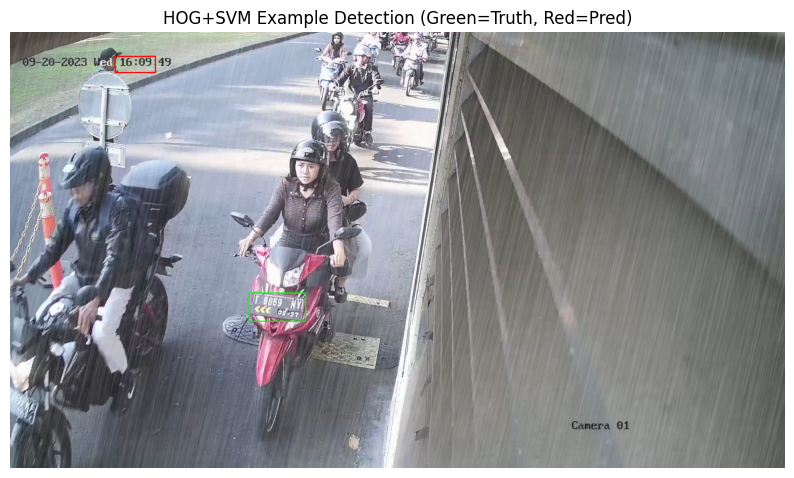

Evaluating on Test Set: 100%|██████████| 400/400 [1:45:17<00:00, 15.79s/it]


--- Evaluation Metrics (IoU Threshold = 0.5) ---
Precision: 0.2049
Recall:    0.5025
F1-Score:  0.2911


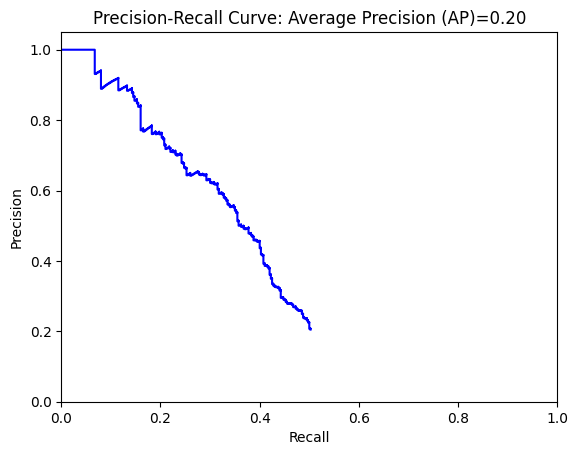

--- Part 4: Method 2 - Viola-Jones (Haar Cascade) ---
TRAINING a custom Haar Cascade is done via command line, not in Python.
1. Collect positive samples (your plates, cropped) and negative images (no plates).
2. Use `opencv_createsamples` to generate a .vec file from positive samples.
3. Use `opencv_traincascade` to train the classifier. Example command:
   `opencv_traincascade -data cascade/ -vec samples.vec -bg negatives.txt -numStages 20 -w 100 -h 40`

DEMONSTRATING usage with OpenCV's pre-trained Russian plate detector:
Viola-Jones found 0 potential plates in the test image.


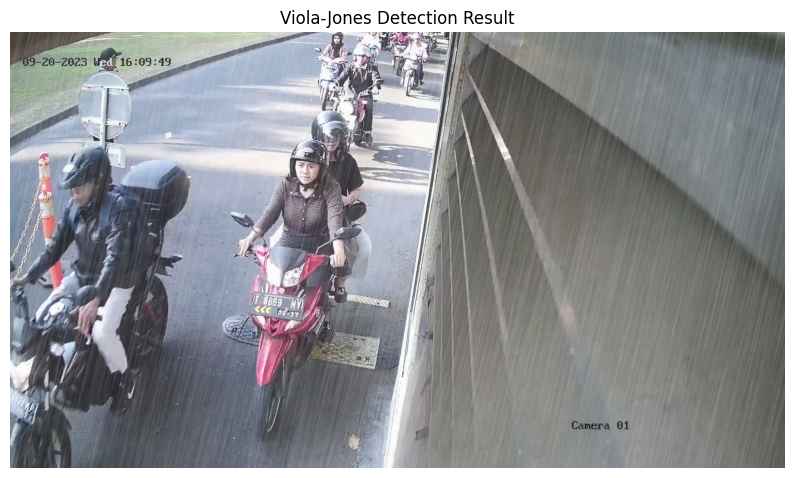

In [16]:
# --- Load Data ---
train_paths, train_annots = load_yolo_dataset(Config.DATASET_ROOT, 'train')
test_paths, test_annots = load_yolo_dataset(Config.DATASET_ROOT, 'test')

# --- HOG + SVM Pipeline ---
if train_paths and test_paths:
    # Prepare features from the training set
    pos_feats, neg_feats = prepare_training_data(train_paths, train_annots)

    # Train the classifier
    svm_model = train_svm_classifier(pos_feats, neg_feats)

    # Evaluate the model on the test set
    evaluate_model(svm_model, test_paths, test_annots)
    
    # --- Viola-Jones Demonstration ---
    explain_and_use_haar_cascade(test_paths[0])
else:
    print("Execution halted because data could not be loaded. Please check your folder structure.")